# This notebook compares the cross-linking data to the ground truth data.

In [1]:
import os
import yaml
import glob
import sys
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pyRBDome.Functions.RBDomeAnalysisCode import *
from pyRBDome.Functions.RBDomeSQL import *
from pyRBDome.Classes.PDBAnalyser import * 
from scipy.stats import ks_2samp,kstest
from sklearn.metrics import confusion_matrix

matplotlib.rcParams['font.family'] = 'Arial'

In [2]:
settings_file = open('settings.yaml','r')
settings = yaml.load(settings_file,Loader=yaml.FullLoader)

In [3]:
### Parameters:
out_dir = os.path.abspath(settings[0]['general']['out_dir'])
data = os.path.abspath(settings[0]['general']['datafile'])
pdb_dir = os.path.abspath(settings[0]['general']['pdb_dir'])
proteome = os.path.abspath(settings[0]['general']['proteome'])

### Database parameters
database_name = settings[4]['database']['database_name']

In [4]:
out_dir

'/home/pyrbdome/Documents/pyRBDome_analyses/Sander_Granneman/pyRBDome_Notebooks_Ground_truth_analyses/analysis_results'

In [5]:
database_name

'pyrbdome_full.db'

In [6]:
listTablesFromSQLite(database_name)

['interpro_results',
 'InterProScan_Pfam_data',
 'available_pdbs',
 'pyrbdome_analysis',
 'processed_files_log',
 'trypsin_in_silico_peptides',
 'Lys_C_in_silico_peptides',
 'random_peptides',
 'RNA_binding_peptides_with_match_in_pdb',
 'trypsin_peptides_with_match_in_pdb',
 'lys_C_peptides_with_match_in_pdb',
 'random_peptides_with_match_in_pdb',
 'RNA_binding_amino_acids_with_match_in_pdb',
 'trypsin_amino_acids_with_match_in_pdb',
 'lys_C_amino_acids_with_match_in_pdb',
 'random_amino_acids_with_match_in_pdb',
 'All_combined_results',
 'Experimental_and_Ground_Truth_data']

### Loading all the experimental and ground truth data file:

In [7]:
exp_gt_table = loadTableFromSQLite('Experimental_and_Ground_Truth_data',database_name,verbose=True)

Table 'Experimental_and_Ground_Truth_data' successfully loaded from database 'pyrbdome_full.db' 


In [8]:
exp_gt_table.head()

ID         pdb_id  residue_number amino_acid  Peptide  \
0  P23396  P23396_merged               1          M      NaN   
1  P23396  P23396_merged               2          A      NaN   
2  P23396  P23396_merged               3          V      NaN   
3  P23396  P23396_merged               4          Q      NaN   
4  P23396  P23396_merged               5          I      NaN   

   Cross-linked_amino_acid  Distance_to_RNA hbond hydrophobic saltbridge  \
0                      NaN             8.07  None        None       None   
1                      NaN             4.78  None        None       None   
2                      NaN             2.88  None        None       None   
3                      NaN             2.62  None        None       None   
4                      NaN             2.85  None        None       None   

  pication pistacking   all  Distance_to_PLIP  
0     None       None  None               NaN  
1     None       None  None               NaN  
2     None       None  None               NaN  
3     None       None  None               NaN  
4     None       None  None               NaN

### Loading the table containing all the data:

In [45]:
all_results_table = loadTableFromSQLite('All_combined_results',database_name,verbose=True)

Table 'All_combined_results' successfully loaded from database 'pyrbdome_full.db' 


### Now converting the data containing prediciton results to numerical values:

In [46]:
numerical_columns = ['aaRNA','PST_PRNA','BindUP','FTMap_distances','RNABindRPlus',
                     'DisoRDPbind','HydRa','Distance_to_RNA','PLIP']

In [47]:
all_results_table = convertToNumeric(all_results_table,numerical_columns)

In [48]:
all_results_table.head()

ID         pdb_id  residue_number amino_acid  aaRNA PST_PRNA BindUP  \
0  P23396  P23396_merged               1          M  53.46      0.0    0.0   
1  P23396  P23396_merged               2          A  47.02     0.02    0.0   
2  P23396  P23396_merged               3          V  37.38     0.01    0.0   
3  P23396  P23396_merged               4          Q  57.55     0.16    0.0   
4  P23396  P23396_merged               5          I  42.46     0.05    0.0   

  FTMap_distances  RNABindRPlus  DisoRDPbind  HydRa  Distance_to_RNA PLIP  \
0           14.07          0.25         0.16    0.0             8.07  NaN   
1           14.31          0.24         0.17    0.0             4.78  NaN   
2            9.73          0.68         0.17    0.0             2.88  NaN   
3           11.99          0.68         0.17    0.0             2.62  NaN   
4            8.22          0.13         0.16    0.0             2.85  NaN   

   Distance_to_PLIP  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN

### Let's have a look at the cross-linked amino acids:

In [49]:
cross_linked_aa_data = exp_gt_table[exp_gt_table['Cross-linked_amino_acid'] == 1]

In [50]:
cross_linked_aa_data.head()

ID         pdb_id  residue_number amino_acid  Peptide  \
53  P23396  P23396_merged              54          R      1.0   
57  P23396  P23396_merged              58          V      1.0   
82  P23396  P23396_merged              83          S      1.0   
86  P23396  P23396_merged              87          Y      1.0   
89  P23396  P23396_merged              90          K      1.0   

    Cross-linked_amino_acid  Distance_to_RNA hbond hydrophobic saltbridge  \
53                      1.0            16.18  None        None       None   
57                      1.0            18.13  None        None       None   
82                      1.0            12.49  None        None       None   
86                      1.0            18.25  None        None       None   
89                      1.0            16.53  None        None       None   

   pication pistacking   all  Distance_to_PLIP  
53     None       None  None               NaN  
57     None       None  None               NaN  
82     None       None  None               NaN  
86     None       None  None               NaN  
89     None       None  None               NaN

### Now let's compare the prediction results to the ground truth data:

### Let's binarise the prediction results:

In [51]:
threshold_dict = {
    'PST_PRNA':('>=',0.4),
    'aaRNA':('>=',18),
    'BindUP':('>=',10),
    'FTMap_distances':('<=',4.2),
    'RNABindRPlus':('>=',0.5),
    'DisoRDPbind':('>=',0.16),
    'HydRa':('>=',1.0),
    'Distance_to_RNA': ('<=',4.2),
    }

In [52]:
binarised = all_results_table.copy(deep=True)

In [53]:
for i in threshold_dict:
    character,threshold = threshold_dict[i]
    predictions = pd.to_numeric(binarised[i])
    if character == '>=':
        predictions = [1 if i >= threshold else 0 for i in predictions]
        binarised[i] = predictions
    elif character == '<=':
        predictions = [1 if i <= threshold else 0 for i in predictions]
    elif character == '==':
        predictions = [1 if i == threshold else 0 for i in predictions]
    
    # Setting the new values:
    binarised[i] = predictions

In [54]:
binarised.head()

ID         pdb_id  residue_number amino_acid  aaRNA  PST_PRNA  BindUP  \
0  P23396  P23396_merged               1          M      1         0       0   
1  P23396  P23396_merged               2          A      1         0       0   
2  P23396  P23396_merged               3          V      1         0       0   
3  P23396  P23396_merged               4          Q      1         0       0   
4  P23396  P23396_merged               5          I      1         0       0   

   FTMap_distances  RNABindRPlus  DisoRDPbind  HydRa  Distance_to_RNA PLIP  \
0                0             0            1      0                0  NaN   
1                0             0            1      0                0  NaN   
2                0             1            1      0                1  NaN   
3                0             1            1      0                1  NaN   
4                0             0            1      0                1  NaN   

   Distance_to_PLIP  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN

### Now plotting the confusion matrices:

In [55]:
def calculate_performance_metrics(conf_matrix):
    # Extracting the four elements of the confusion matrix
    TN, FP, FN, TP = conf_matrix.ravel()

    # Calculating metrics
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    # Calculating the mathews correlaion coefficient:
    numerator = (TP * TN) - (FP * FN)
    denominator = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
    mcc = numerator / denominator if denominator else 0

    return accuracy, precision, recall, f1_score, mcc

In [95]:
selection = list(threshold_dict.keys())[0:-2]

In [97]:
selection

['PST_PRNA',
 'aaRNA',
 'BindUP',
 'FTMap_distances',
 'RNABindRPlus',
 'DisoRDPbind']

In [98]:
plip_results = pd.DataFrame(index=selection,columns=['accuracy','precision','recall','f1_score','mcc'])

In [99]:
proteins_with_plip_data = sorted(set(binarised.loc[binarised['PLIP'] >= 1,'ID']))

In [100]:
proteins_with_plip_data[:5]

['B3Y653', 'G1SP51', 'G1SS70', 'G1SVB0', 'G1TIB4']

In [101]:
all_data_with_plip = binarised.loc[binarised['ID'].isin(proteins_with_plip_data)]

In [115]:
ground_truth = [int(i) for i in all_data_with_plip['PLIP'].values]
ground_truth = [1 if i >= 1 else 0 for i in all_data_with_plip['PLIP'].values]

In [116]:
all_data_with_plip.head()

ID         pdb_id  residue_number amino_acid  aaRNA  PST_PRNA  \
227  P37108  P37108_merged               2          V      0         1   
228  P37108  P37108_merged               3          L      0         0   
229  P37108  P37108_merged               4          L      0         0   
230  P37108  P37108_merged               5          E      0         0   
231  P37108  P37108_merged               6          S      0         0   

     BindUP  FTMap_distances  RNABindRPlus  DisoRDPbind  HydRa  \
227       1                1             0            0      0   
228       1                1             0            0      0   
229       0                1             0            0      0   
230       0                1             0            0      0   
231       0                1             0            0      0   

     Distance_to_RNA PLIP  Distance_to_PLIP  
227                1  1.0          0.000000  
228                0  0.0          1.325162  
229                0  0.0          1.332028  
230                1  1.0          0.000000  
231                0  0.0          1.323984

In [119]:
plip_results.head()

accuracy precision recall f1_score  mcc
PST_PRNA             NaN       NaN    NaN      NaN  NaN
aaRNA                NaN       NaN    NaN      NaN  NaN
BindUP               NaN       NaN    NaN      NaN  NaN
FTMap_distances      NaN       NaN    NaN      NaN  NaN
RNABindRPlus         NaN       NaN    NaN      NaN  NaN

In [120]:
selection

['PST_PRNA',
 'aaRNA',
 'BindUP',
 'FTMap_distances',
 'RNABindRPlus',
 'DisoRDPbind']

In [121]:
all_data_with_plip

ID         pdb_id  residue_number amino_acid  aaRNA  PST_PRNA  \
227    P37108  P37108_merged               2          V      0         1   
228    P37108  P37108_merged               3          L      0         0   
229    P37108  P37108_merged               4          L      0         0   
230    P37108  P37108_merged               5          E      0         0   
231    P37108  P37108_merged               6          S      0         0   
...       ...            ...             ...        ...    ...       ...   
97712  Q9Y580  Q9Y580_merged              81          K      1         1   
97713  Q9Y580  Q9Y580_merged              82          I      0         1   
97714  Q9Y580  Q9Y580_merged              83          Q      1         1   
97715  Q9Y580  Q9Y580_merged              84          F      0         0   
97716  Q9Y580  Q9Y580_merged              85          R      1         1   

       BindUP  FTMap_distances  RNABindRPlus  DisoRDPbind  HydRa  \
227         1                1             0            0      0   
228         1                1             0            0      0   
229         0                1             0            0      0   
230         0                1             0            0      0   
231         0                1             0            0      0   
...       ...              ...           ...          ...    ...   
97712       1                1             1            0      0   
97713       0                0             0            0      0   
97714       0                1             1            0      0   
97715       0                1             1            0      0   
97716       1                1             1            0      0   

       Distance_to_RNA PLIP  Distance_to_PLIP  
227                  1  1.0          0.000000  
228                  0  0.0          1.325162  
229                  0  0.0          1.332028  
230                  1  1.0          0.000000  
231                  0  0.0          1.323984  
...                ...  ...               ...  
97712                1  1.0          0.000000  
97713                0  0.0          1.328583  
97714                1  1.0          0.000000  
97715                1  2.0          0.000000  
97716                1  1.0          0.000000  

[65966 rows x 14 columns]

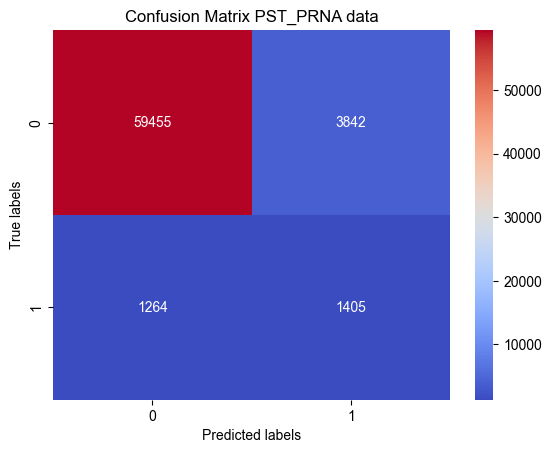

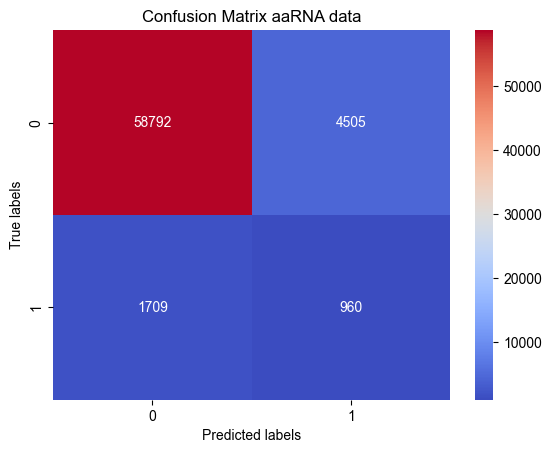

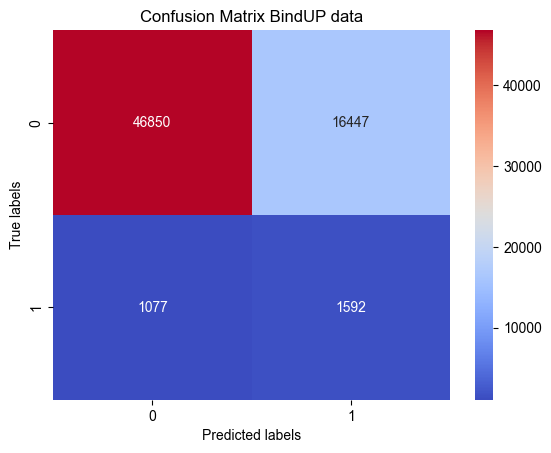

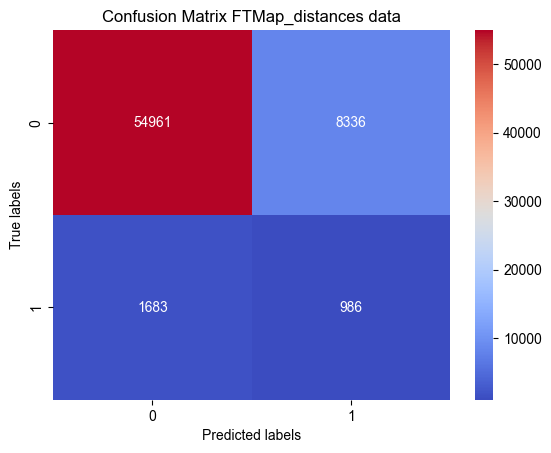

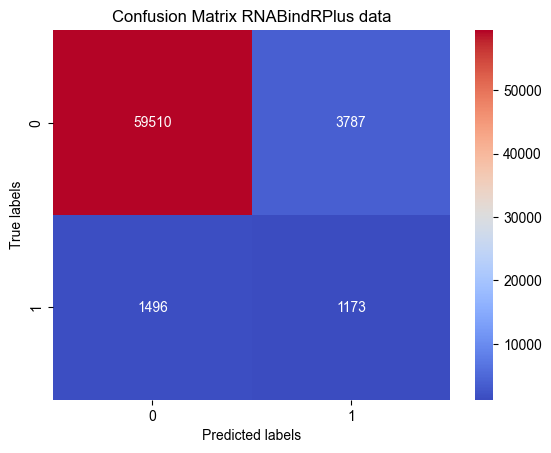

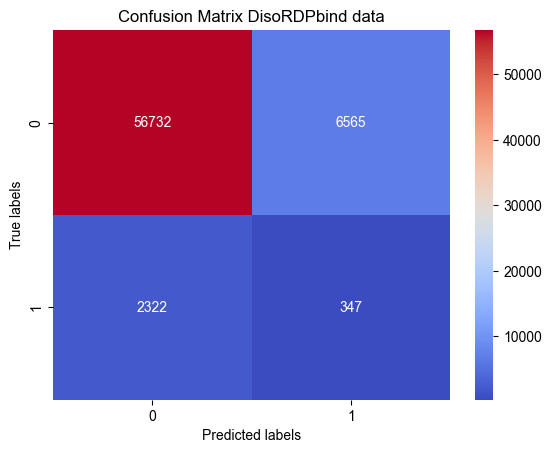

In [124]:
for i in selection:
    predictions = all_data_with_plip[i].values
    conf_matrix = confusion_matrix(ground_truth, predictions)
    plip_results.loc[i,plip_results.columns] = calculate_performance_metrics(conf_matrix)
    
    sns.heatmap(conf_matrix, annot=True, fmt='g',cmap='coolwarm')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix {i} data')
    plt.savefig(f'{out_dir}/PLIP_Confusion_Matrix_{i}_data.pdf')
    plt.show()

In [125]:
# Convert all columns of DataFrame to float
plip_results = plip_results.astype(float)

# Sort tje table by accuray:
plip_results.sort_values(by='accuracy',ascending=False,inplace=True)

In [126]:
plip_results

accuracy  precision    recall  f1_score       mcc
PST_PRNA         0.922596   0.267772  0.526414  0.354977  0.339133
RNABindRPlus     0.919913   0.236492  0.439490  0.307511  0.283684
aaRNA            0.905800   0.175663  0.359685  0.236046  0.206231
DisoRDPbind      0.865279   0.050203  0.130011  0.072435  0.016916
FTMap_distances  0.848119   0.105771  0.369427  0.164457  0.134468
BindUP           0.734348   0.088253  0.596478  0.153757  0.148811

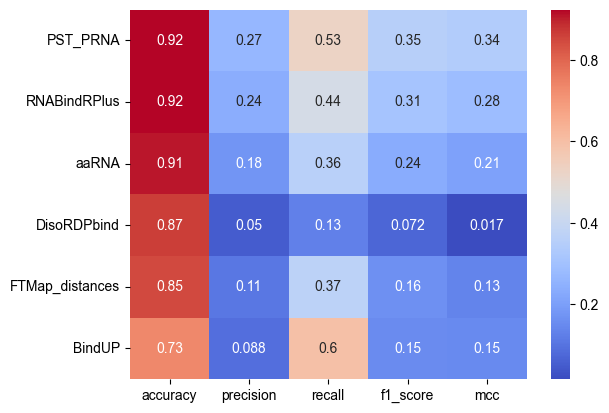

In [127]:
fig,ax = plt.subplots()
sns.heatmap(plip_results, annot=True, cmap='coolwarm',ax=ax)
fig.savefig(f'{out_dir}/PLIP_Tool_performance_metrics.pdf',dpi=400)

### Now doing the same for the distance analyses:

In [128]:
distance_results = pd.DataFrame(index=selection,columns=['accuracy','precision','recall','f1_score','mcc'])

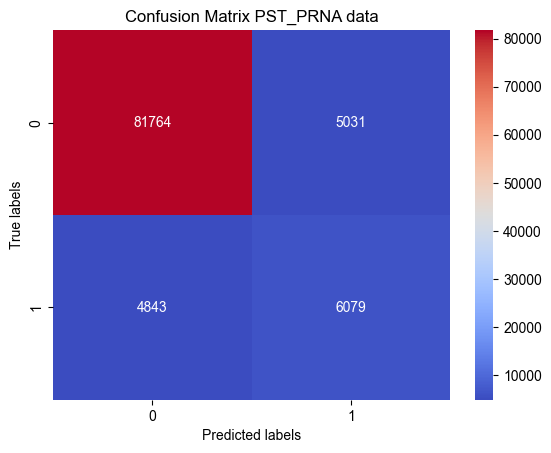

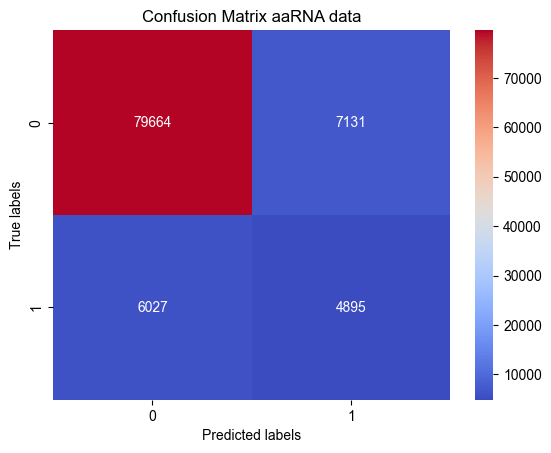

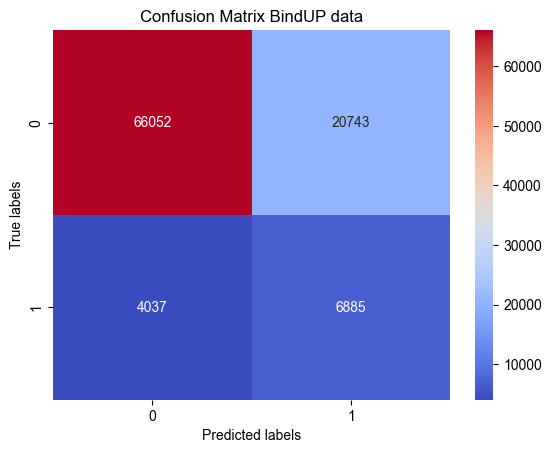

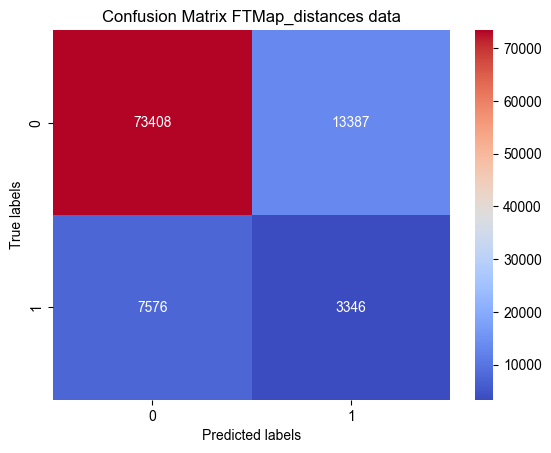

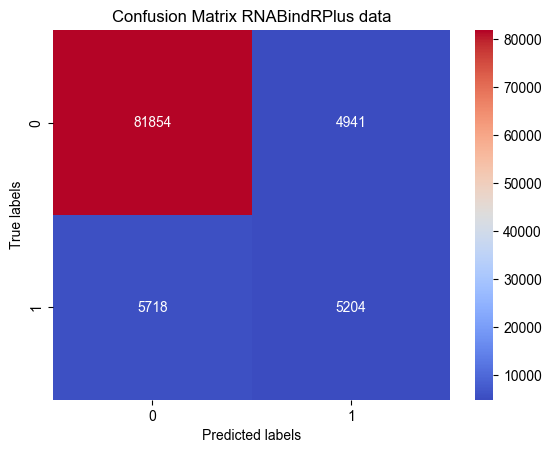

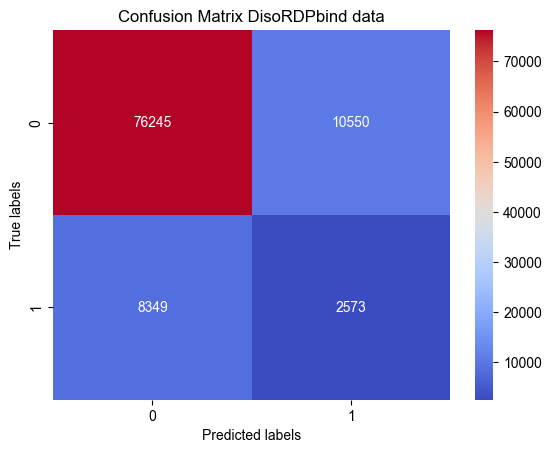

In [129]:
ground_truth = binarised['Distance_to_RNA']

for i in selection:
    predictions = binarised[i]
    conf_matrix = confusion_matrix(ground_truth, predictions)
    distance_results.loc[i,distance_results.columns] = calculate_performance_metrics(conf_matrix)
    
    sns.heatmap(conf_matrix, annot=True, fmt='g',cmap='coolwarm')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix {i} data')
    plt.savefig(f'{out_dir}/Distance_Confusion_Matrix_{i}_data.pdf')
    plt.show()

In [130]:
# Convert all columns of DataFrame to float
distance_results = distance_results.astype(float)

# Sort tje table by accuray:
distance_results.sort_values(by='accuracy',ascending=False,inplace=True)

In [131]:
distance_results

accuracy  precision    recall  f1_score       mcc
PST_PRNA         0.898953   0.547165  0.556583  0.551834  0.494918
RNABindRPlus     0.890920   0.512962  0.476470  0.494043  0.433377
aaRNA            0.865346   0.407035  0.448178  0.426617  0.351054
DisoRDPbind      0.806595   0.196068  0.235580  0.214015  0.105372
FTMap_distances  0.785472   0.199964  0.306354  0.241982  0.127230
BindUP           0.746411   0.249204  0.630379  0.357198  0.273848

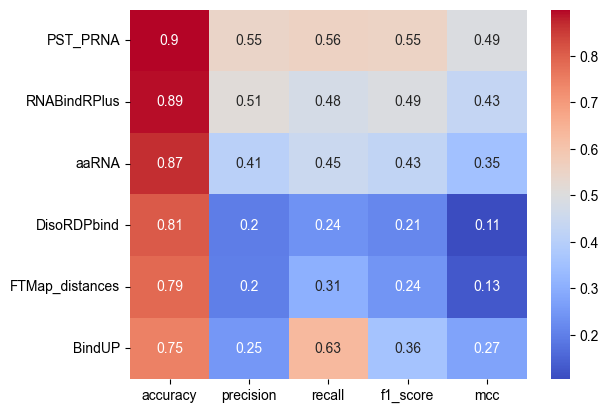

In [132]:
fig,ax = plt.subplots()
sns.heatmap(distance_results, annot=True, cmap='coolwarm',ax=ax)
fig.savefig(f'{out_dir}/Distance_analyses_Tool_performance_metrics.pdf',dpi=400)